<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4654/logos/front_page.png"/>
# <span style="color:blue;text-align:center;">Trip Type Classification: v2 Feature Engineering</span>

Walmart uses both art and science to continually make progress on their core mission of better understanding and serving their customers. One way Walmart is able to improve customers' shopping experiences is by segmenting their store visits into different trip types.
<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4654/media/walmart_triptypes640.png"/>

## Import Packages

In [1]:
using DataFrames
using MLBase
using Gadfly

  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/modeltune.jl:5
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:104
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:105
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163
  likely near /Users/diego/.julia/v0.4/MLBase/src/deprecated/datapre.jl:163


## Load Data

In [2]:
train = readtable("data/train.csv.gz")
test = readtable("data/test.csv.gz")
full = vcat(train, test);

## Visualize Sample Data

In [3]:
@show size(train)
@show size(test)
@show size(full);

size(train) = (647054,7)

In [4]:
head(full)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
1,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000
2,30,7,Friday,60538815980,1,SHOES,8931
3,30,7,Friday,7410811099,1,PERSONAL CARE,4504
4,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565
5,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017
6,26,8,Friday,2006618783,2,PAINT AND ACCESSORIES,1017



size(test) = (653646,6)
size(full) = (1300700,7)


In [5]:
showcols(train)
showcols(test)

647054x7 DataFrames.DataFrame
| Col #

## Data Uniquiness

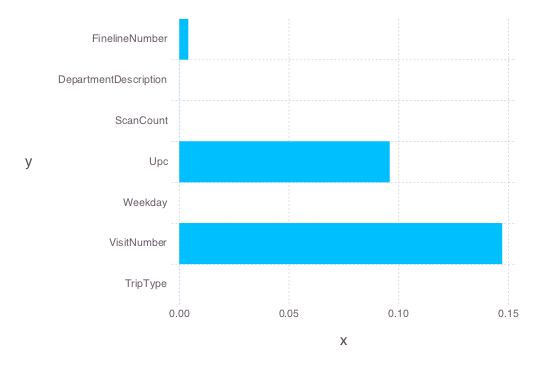

In [14]:
plot(x=map(c -> length(Set(dropna(full[c])))/length(dropna(full[c])), names(full)), 
     y=names(full), Geom.bar(orientation=:horizontal))

## Handle Missing Data

In [15]:
apply_default_null_column!(df, column, value) = df[isna(df[column]), column] = value;

In [8]:
[apply_default_null_column!(df, :Upc, -1) for df in [train, test, full]]
[apply_default_null_column!(df, :FinelineNumber, -1) for df in [train, test, full]]
apply_default_null_column!(full, :TripType, median(dropna(full[:TripType])));

## Feature Encoding

In [16]:
categorical_features = [:TripType, :Weekday, :Upc, :DepartmentDescription, :FinelineNumber];

In [17]:
apply_encoding!(df, column, label) = df[column] = labelencode(label, df[column])

apply_encoding! (generic function with 1 method)

In [18]:
labels = Dict({column => labelmap(convert(Array, dropna(full[column]))) for column in categorical_features});


Use "Dict{Any,Any}([a=>b for (a,b) in c])" instead.


In [19]:
[apply_encoding!(train, column, labels[column]) for column in categorical_features]
[apply_encoding!(test, column, labels[column]) for column in setdiff(categorical_features, [:TripType])]
[apply_encoding!(full, column, labels[column]) for column in categorical_features];

## Feature Engineering 

In [22]:
all_upc = Set(full[:Upc])
all_fineline_number = Set(full[:FinelineNumber])
all_departments = Set(full[:DepartmentDescription]);

In [104]:
function add_relationship_feature!(df, column, all_possible_values_list)
    data = Array[]
    for subdf in groupby(df, column)
        row = []
        for value in all_possible_values_list
            push!(row, value in subdf[column]? 1 : 0)
        end
        
        for i=1:size(subdf, 1)
            push!(data, row)
        end
    end
    
    nrows, ncols = size(data)[1], size(data[1])[1]
    data = reshape(vcat(data...), (ncols, nrows))
    for (i, value) in enumerate(all_possible_values_list)
        df[symbol(string(column, "_", value))] = vcat(data[i, :]...)
    end
    
    return df
end

add_relationship_feature! (generic function with 1 method)

### Add UPC as Relational Feature

In [110]:
add_relationship_feature!(train, :Upc, all_departments)
add_relationship_feature!(test, :Upc, all_departments)
add_relationship_feature!(full, :Upc, all_departments);

### Add FinelineNumber as Relational Feature

In [109]:
add_relationship_feature!(train, :FinelineNumber, all_departments)
add_relationship_feature!(test, :FinelineNumber, all_departments)
add_relationship_feature!(full, :FinelineNumber, all_departments);

### Add Department as Relational Feature

In [ ]:
add_relationship_feature!(train, :DepartmentDescription, all_departments)
add_relationship_feature!(test, :DepartmentDescription, all_departments)
add_relationship_feature!(full, :DepartmentDescription, all_departments);

### Store Feature Engineering

In [111]:
writetable("data/train_featured_all_relationship.tsv", train, separator='\t')
writetable("data/test_featured_all_relationship.tsv", test, separator='\t')
writetable("data/full_featured_all_relationship.tsv", full, separator='\t');